# Практика №3

Теперь в качестве акустической модели мы будем использовать простой DNN классификатор. На каждом кадре записи мы будем подавать его вектор признаков на DNN, которая будет выдавать "распределение вероятностей" по фонемам. Далее это распределение мы будем использовать в нашем алгоритме распознавания по словарю. Схема работы такого классификатора представлена ниже: 

![](https://drive.google.com/uc?export=view&id=1dv0VuE8DIoKXETbvnZq2PMixkWMCJOxr)

### Bootstrap

In [1]:
!pip install --upgrade --no-cache-dir gdown

!gdown --id '1meikF0XqBUnVZKoY3160MQ0R25lq-EMu'
!gdown --id '1f0LkW6I3Q5CnOThuNFAJ9umgnb2eU4Ox'

!unzip -q lab2.zip
!unzip -q train_librispeech_10h.zip
!mv lab2 lab3
!mv train_librispeech_10h lab3/data
!rm -rf lab2.zip sample_data train_librispeech_10h.zip
%cd lab3

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1meikF0XqBUnVZKoY3160MQ0R25lq-EMu
To: /content/lab2.zip
100% 1.66M/1.66M [00:00<00:00, 99.2MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1f0LkW6I3Q5CnOThuNFAJ9umgnb2eU4Ox
To: /content/train_librispeech_10h.zip
100% 679M/679M [00:05<00:00, 123MB/s]
/content/lab3


In [2]:
import os
import numpy as np
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa, librosa.display
import torch
import torch.nn as nn
import torch.functional as F
import warnings

warnings.filterwarnings('ignore')
torch.manual_seed(42)
np.random.seed(42)

%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [3]:
# загрузка списка допустимых фонем:
def load_phones_dict(phones_file):
    phones_dict = {}
    with open(phones_file, encoding='utf-8') as fn:
        for index, line in enumerate(fn):
            phones_dict[line.strip()] = index
    return phones_dict

# загрузка покадровой фонемной разметки в словарь:
def load_phone_aligment(aligment_file):
    ali_dict = {}
    with open(aligment_file, encoding='utf-8') as fn:
        for line in fn:
            line = line.strip().split()
            ali_dict[line[0]] = line[1:]
    return ali_dict

# подсчет акустиеских признаков для записей из папки:
def load_data_dict(dir_path, count=None):
    data_dict = {}
    step = 0
    for wav_name in tqdm(os.listdir(dir_path)):
        x, sr = librosa.load(os.path.join(dir_path, wav_name), sr=None) 
        mfcc = librosa.feature.mfcc(x,
                                    sr=sr,
                                    n_mfcc=13, 
                                    n_fft=int(sr * 0.025),
                                    hop_length=int(sr * 0.01))
        step += 1
        if count and step == count:
            print(f'Early stop at {step}th file..')
            break
        data_dict[wav_name.split('.')[0]] = mfcc.T  
    return data_dict


phones_file = 'data/train_librispeech_10h/phones'
phones_dict = load_phones_dict(phones_file)

ali_file = 'data/train_librispeech_10h/ali_phones.txt'
ali_dict = load_phone_aligment(ali_file)

train_records_dir = 'data/train_librispeech_10h/wav_dir'
feats_dict = load_data_dict(train_records_dir, count=1000)

  0%|          | 0/3000 [00:00<?, ?it/s]

Early stop at 1000th file..


### Априорная вероятность:

![](https://drive.google.com/uc?export=view&id=1WhjclhXm2POYsCgvxp3iAIOvT9F_k8If)

http://data-science.wiki/images/Automatic_Speech_Recognition_RxtNVMXYTy.pdf

In [4]:
# Функция для создания данных с контекстом
def make_windowed_data(file_feats, side_context):

    data = np.pad(
        file_feats,
        pad_width=((side_context, side_context), (0, 0)),
        mode='edge'
    )

    windowed_data = np.array([np.concatenate(
        data[frame - side_context:frame + side_context + 1]
    ) for frame in range(side_context, len(data) - side_context)])
    
    return windowed_data

In [5]:
# объединение кадров признаков с соответствующими им фонемам:
def combain_data(ali_dict, feats_dict, phones_dict, side_context=0):
    data_list = []
    priors_list = [0] * len(phones_dict)
    for file_name in feats_dict.keys():
        file_feats = feats_dict[file_name]
        file_feats = make_windowed_data(file_feats, side_context)
        file_ali = ali_dict[file_name]
        for frame in range(min(len(file_feats), len(file_ali))):
            data_list.append(np.append(file_feats[frame], phones_dict[file_ali[frame]]))
            priors_list[phones_dict[file_ali[frame]]] += 1
    return data_list, np.array(priors_list)/sum(priors_list)

side_context = 0
data_list, priors_list = combain_data(ali_dict, feats_dict, phones_dict, side_context)
data_list = np.random.permutation(data_list)

In [6]:
class CommonDataSet():

    def __init__(self, data_list, device, valid_proportion=0.1):
        self.train = data_list[:int((1-valid_proportion)*len(data_list))]
        self.valid = data_list[int((1-valid_proportion)*len(data_list)):]
        self.device = device
        
    def num_batches(self, batch_size):
        return len(self.train)//batch_size        
        
    def next_batch(self, batch_size):
        for i in range(self.num_batches(batch_size)):
            batch_xs = torch.tensor(self.train[i * batch_size:(i + 1) * batch_size, :-1], dtype=torch.float32)
            batch_ys = torch.tensor(self.train[i * batch_size:(i + 1) * batch_size,-1].ravel(), dtype=torch.int64)

            yield batch_xs.to(device), batch_ys.to(device)

In [7]:
class MyNNet(torch.nn.Module):

    def __init__(self, input_dim, output_dim):
        super(MyNNet, self).__init__()
        # params:
        ff_dim = 256

        self.ff_net = torch.nn.Sequential(
            nn.Linear(input_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, output_dim),
        )


    def forward(self, x):
        x = self.ff_net(x)
        return (x)

In [8]:
def train(nnet, data_set, batch_size, num_epochs, criterion, optimizer):
    start = time.time() 
    loss_list = []

    print('TRAINIG STARTED...')
    for epoch in range(num_epochs):
        running_loss = 0
        counter = 0
        for batch_xs, batch_ys in tqdm(data_set.next_batch(batch_size), \
                                      total=data_set.num_batches(batch_size), \
                                      desc='epoch {}'.format(epoch)):
            optimizer.zero_grad()
            output = nnet(batch_xs)

            loss = criterion(output, batch_ys)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            counter += 1
            
        print('loss is: {:.4f}'.format((running_loss / counter)))
        loss_list.append(running_loss / counter)
        
    end = time.time()
    minutes = (end - start) // 60
    seconds = np.mod((end - start), 60)
    print('Time is: {} min {} sec'.format(int(minutes), int(seconds)))
    
    return loss_list

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load data:
data_set = CommonDataSet(data_list, device)

batch_size = 256
num_epochs = 10

nnet = MyNNet(input_dim=(data_list[0].shape[0] - 1),
            output_dim=len(phones_dict.keys())).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nnet.parameters(), lr=0.0001)

loss_list = train(
    nnet=nnet,
    data_set=data_set,
    batch_size=batch_size,
    num_epochs=num_epochs,
    criterion=criterion,
    optimizer=optimizer
)

TRAINIG STARTED...


epoch 0:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 2.4957


epoch 1:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 2.2582


epoch 2:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 2.2192


epoch 3:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 2.1924


epoch 4:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 2.1711


epoch 5:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 2.1541


epoch 6:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 2.1404


epoch 7:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 2.1290


epoch 8:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 2.1196


epoch 9:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 2.1110
Time is: 1 min 45 sec


In [10]:
def plot_loss_history(loss_list):
    plt.rcParams['figure.figsize'] = (15.0, 5.0)
    plt.plot(loss_list)
    plt.title('Loss per epoch')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.grid()
    plt.show()

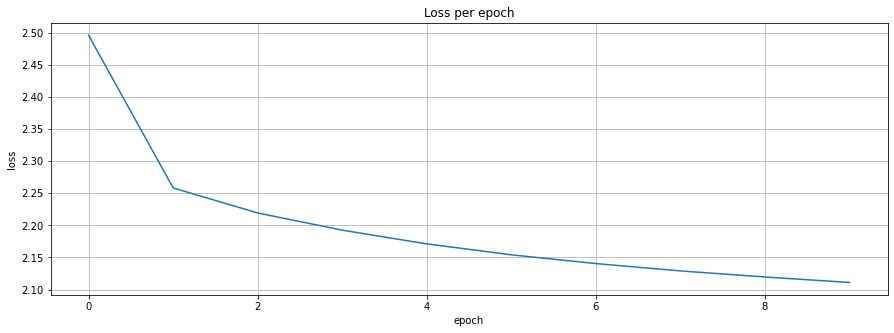

In [11]:
plot_loss_history(loss_list)

In [12]:
def accuracy(nnet, data_set, phones_dict=phones_dict):
    class_correct = [0 for x in range(len(phones_dict.keys()))]
    class_total = [0 for x in range(len(phones_dict.keys()))]

    nnet.cpu()

    with torch.no_grad():
        correct_cnt = 0
        for ftr, true_label in tqdm(zip(data_set.valid[:, :-1], data_set.valid[:, -1]), total=data_set.valid.shape[0]):
            ftr = torch.from_numpy(ftr).float()
            output = nnet.forward(ftr)
            predicted_label = output.argmax().item()
            correct_cnt += (predicted_label == true_label)
            class_correct[predicted_label] += (predicted_label == int(true_label))
            class_total[int(true_label)] += 1
            
    print("Total frame accuracy is {:.3f}\n".format(correct_cnt / data_set.valid.shape[0]))

    for idx, phone in enumerate(phones_dict.keys()):
        if class_total[idx]:
            print('{:3s}: {:.2f} : {}/{}'.format(phone, class_correct[idx] / class_total[idx], \
                                                        class_correct[idx], class_total[idx]))

In [13]:
accuracy(nnet, data_set)

  0%|          | 0/127534 [00:00<?, ?it/s]

Total frame accuracy is 0.413

SIL: 0.96 : 22053/22941
SPN: 0.00 : 0/766
AA0: 0.00 : 0/46
AA1: 0.30 : 536/1799
AA2: 0.00 : 0/84
AE0: 0.00 : 0/52
AE1: 0.38 : 1388/3615
AE2: 0.00 : 0/94
AH0: 0.24 : 1352/5575
AH1: 0.28 : 526/1861
AH2: 0.00 : 0/43
AO0: 0.00 : 0/36
AO1: 0.35 : 675/1912
AO2: 0.00 : 0/68
AW0: 0.00 : 0/11
AW1: 0.06 : 62/1100
AW2: 0.00 : 0/35
AY0: 0.00 : 0/37
AY1: 0.18 : 575/3134
AY2: 0.00 : 0/143
B  : 0.09 : 130/1525
CH : 0.04 : 32/872
D  : 0.23 : 914/3964
DH : 0.06 : 115/1966
EH0: 0.00 : 0/58
EH1: 0.27 : 763/2856
EH2: 0.00 : 0/84
ER0: 0.26 : 679/2611
ER1: 0.13 : 128/1017
ER2: 0.00 : 0/20
EY0: 0.00 : 0/23
EY1: 0.44 : 1024/2344
EY2: 0.00 : 0/155
F  : 0.38 : 907/2374
G  : 0.01 : 7/797
HH : 0.18 : 386/2166
IH0: 0.06 : 152/2608
IH1: 0.18 : 431/2332
IH2: 0.00 : 0/106
IY0: 0.24 : 500/2070
IY1: 0.47 : 1094/2324
IY2: 0.00 : 0/70
JH : 0.01 : 9/687
K  : 0.23 : 678/3010
L  : 0.55 : 2288/4152
M  : 0.35 : 1080/3083
N  : 0.46 : 2737/6005
NG : 0.07 : 89/1286
OW0: 0.01 : 1/177
OW1: 0.21 : 391

### Распознавание по словарю с помощью нейронной сети

In [14]:
# теперь будем распознавать по словарю, состоящему из конечных слов
# для этого нужно загрузить файл лексикона, который определяет из каких фонем состоят наши слова
def load_lexicon_dict(lexicon_file):
    lexicon_dict = {}
    with open(lexicon_file, encoding='utf-8') as fn:
        for line in fn:
            line = line.strip().split()
            lexicon_dict[line[0]] = line[1:]
    return lexicon_dict

In [15]:
class AcousticModel:
    def __init__(self, phone_name, phone_index, priors_list):
        self.phone_name = phone_name
        self.phone_index = phone_index
        self.phone_prior = priors_list[phone_index]
        
    def distance(self, input_feats, nnet):
        with torch.no_grad():
            predicts = nnet.forward(torch.tensor(input_feats, dtype=torch.float32))
            softmax = torch.nn.functional.softmax(predicts, dim=0)
        return -np.log(softmax[self.phone_index].item() / self.phone_prior)

class State:
    def __init__(self, model, index):  
        self.model = model                     # вектор признаков узла
        self.is_final = False                  # является ли этот узел финальнвм в слове
        self.word = None                       # слово эталона (назначается только для финального узла)
        self.best_token = None                 # лучший токен (по минимуму дистанции) в узле
        self.current_word = None               # текущее слово эталона
        self.next_states = []                  # список следующих узлов
        self.index = index                     # индекс узла 

        
def load_graph(lexicon_dict, phones_dict, priors_list):
    start_state = State(None, 0)
    graph = [start_state, ]
    state_index = 1
    for word in lexicon_dict.keys():
        previous_state = start_state
        for phone in lexicon_dict[word]:
            state = State(AcousticModel(phone, phones_dict[phone], priors_list), state_index)
            state.current_word = word           # слово эталона теперь будет храниться в каждом узле
            state.next_states.append(state)     # add loop
            previous_state.next_states.append(state)
            previous_state = state 
            graph.append(state)
            state_index += 1
        if state:
            state.word = word
            state.is_final = True
    return graph

In [16]:
class Token:
    def __init__(self, state, dist=0.0, word=""):
        self.state = state       # стейт графа, в котором токен находится в текущий момент
        self.dist = dist         # общая накопленная дистанция пути, пройденного токеном
        self.word = word         # слово, которое распозналось токеном
        self.alive = True


def beam_pruning(next_tokens, threshold):   
    alive_tokens = [token for token in next_tokens if token.alive]
    best_token = alive_tokens[np.argmin([token.dist for token in alive_tokens if token.alive])]
    for token in next_tokens:
        if token.dist > best_token.dist + threshold:
            token.alive = False
    return next_tokens


def state_pruning(next_tokens, graph):
    for i in range(len(next_tokens)): 
        state_index = next_tokens[i].state.index
        if not graph[state_index].best_token:
            graph[state_index].best_token = next_tokens[i]
        else:
            if next_tokens[i].dist <= graph[state_index].best_token.dist:
                graph[state_index].best_token.alive = False
                graph[state_index].best_token = next_tokens[i]
            else:
                next_tokens[i].alive = False
    for token in next_tokens:                           
        index = token.state.index                        
        if graph[index].best_token:                     
            graph[index].best_token = None              
    return next_tokens


def recognize(filename, features, graph, nnet, recognition_results, beam_threshold):

    start_state = graph[0]
    active_tokens = [Token(start_state), ]
    next_tokens = []
    
    for frame in range(len(features)):
        ftr_frame = features[frame]
        for token in active_tokens:
            if token.alive:
                for transition_state in token.state.next_states:
                    new_token = Token(transition_state, token.dist, token.word)
                    new_token.dist += transition_state.model.distance(ftr_frame, nnet)
                    next_tokens.append(new_token)
        # state and beam prunings:
        next_tokens = state_pruning(next_tokens, graph)         
        next_tokens = beam_pruning(next_tokens, beam_threshold) 

        active_tokens = next_tokens
        next_tokens = []                                    
        
    # поиск финальных токенов:
    final_tokens = []
    for token in active_tokens:
        if token.state.is_final and token.alive:
            final_tokens.append(token)

    # если нет финальных, то берем лучший из выживших:
    if len(final_tokens) != 0:
        win_token = final_tokens[np.argmin([token.dist for token in final_tokens])]
    else:
        alive_tokens = [token for token in active_tokens if token.alive]
        win_token = alive_tokens[np.argmin([token.dist for token in alive_tokens])]
        win_token.state.word = win_token.state.current_word

    # вывод результата
    print(f"result: {filename:<27} ==> {win_token.state.word}")

    # совпадает ли запись с полученным эталоном:  
    record_word = filename.split('_')[0]
    etalon_word = win_token.state.word.split('_')[0]
    recognition_results.append(etalon_word.lower() == record_word)

    return recognition_results

In [17]:
def run_recognizer(records_data_dict, graph, nnet, beam_threshold=10):
    start_time = time.time()
    recognition_results = []

    for filename in records_data_dict.keys():    
        recognition_results = recognize(filename,
                                        records_data_dict[filename],
                                        graph, nnet,
                                        recognition_results, beam_threshold)

    print("-" * 60)
    print(f"WER is: {(1 - sum(recognition_results)/len(recognition_results))*100:.2f}%")
    print(f"Total time is: {time.time() - start_time:.2f} sec")
    print("-" * 60)

### Запустим распознавание на базе YES_NO

In [18]:
def yes_no_check(nnet, side_context=0):
    lexicon_file = 'data/lexicon_yes_no.txt'
    lexicon_dict = load_lexicon_dict(lexicon_file)
    graph = load_graph(lexicon_dict, phones_dict, priors_list)
    records_data_dict = load_data_dict("data/yes_no/records")

    records_data_dict = {
        k: make_windowed_data(v, side_context) for k, v in records_data_dict.items()
    }

    run_recognizer(records_data_dict, graph, nnet.cpu(), beam_threshold=10)

In [19]:
yes_no_check(nnet)

  0%|          | 0/10 [00:00<?, ?it/s]

result: yes_fc94edb0_nohash_0       ==> YES
result: yes_ff63ab0b_nohash_0       ==> YES
result: yes_fe1916ba_nohash_0       ==> YES
result: no_41474817_nohash_0        ==> NO
result: no_49af4432_nohash_0        ==> YES
result: no_ad89eb1e_nohash_0        ==> NO
result: yes_39a12648_nohash_0       ==> YES
result: no_4394fc7c_nohash_0        ==> NO
result: no_4abb2400_nohash_0        ==> YES
result: yes_39a6b995_nohash_0       ==> YES
------------------------------------------------------------
WER is: 20.00%
Total time is: 0.92 sec
------------------------------------------------------------


### Запустим распознавание на базе Digits

In [20]:
def digits_check(nnet, side_context=0):
    lexicon_file = 'data/lexicon_digits.txt'
    lexicon_dict = load_lexicon_dict(lexicon_file)
    graph = load_graph(lexicon_dict, phones_dict, priors_list)
    records_data_dict = load_data_dict("data/digits/records")

    records_data_dict = {
        k: make_windowed_data(v, side_context) for k, v in records_data_dict.items()
    }

    run_recognizer(records_data_dict, graph, nnet.cpu(), beam_threshold=100)

In [21]:
digits_check(nnet)

  0%|          | 0/20 [00:00<?, ?it/s]

result: three_feb1d305_nohash_0     ==> THREE
result: nine_fbe51750_nohash_0      ==> NINE
result: zero_f92e49f3_nohash_3      ==> ZERO
result: one_ffa76c4a_nohash_0       ==> FOUR
result: eight_daf230ac_nohash_0     ==> SIX
result: nine_ccea893d_nohash_0      ==> NINE
result: two_fce65496_nohash_0       ==> SEVEN
result: one_fc2411fe_nohash_0       ==> NINE
result: four_ffbb695d_nohash_0      ==> FOUR
result: zero_f852895b_nohash_0      ==> ZERO
result: five_ffd2ba2f_nohash_0      ==> FIVE
result: five_f852895b_nohash_0      ==> FIVE
result: two_fb2f3242_nohash_0       ==> ZERO
result: six_ffd2ba2f_nohash_0       ==> SIX
result: seven_fd32732a_nohash_0     ==> SEVEN
result: seven_fe5c4a7a_nohash_0     ==> SEVEN
result: six_ffbb695d_nohash_0       ==> SIX
result: four_fce65496_nohash_0      ==> FOUR
result: eight_da584bc0_nohash_4     ==> SIX
result: three_fce96bac_nohash_0     ==> THREE
------------------------------------------------------------
WER is: 30.00%
Total time is: 20.01 se

### <b>Задание №1</b> (5 баллов):
Реализовать контексты для входных признаков путем конкатенации кадров слева и справа от текущего. Не забудьте поддержать это и в функции распознавания. Насколько улучшилось качество на дата сетах?

![](https://drive.google.com/uc?export=view&id=1ft0z6CPhX20cJnA373uLoYwHPEagaKyo)

### **Ответ**:

In [22]:
side_context = 2
batch_size = 256
num_epochs = 10

data_list, priors_list = combain_data(ali_dict, feats_dict, phones_dict, side_context)
data_list = np.random.permutation(data_list)
data_set = CommonDataSet(data_list, device)

nnet = MyNNet(input_dim=(data_list[0].shape[0] - 1),
            output_dim=len(phones_dict.keys())).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nnet.parameters(), lr=0.0001)

loss_list = train(
    nnet=nnet,
    data_set=data_set,
    batch_size=batch_size,
    num_epochs=num_epochs,
    criterion=criterion,
    optimizer=optimizer
)

TRAINIG STARTED...


epoch 0:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 2.2545


epoch 1:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 1.8779


epoch 2:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 1.7928


epoch 3:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 1.7386


epoch 4:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 1.6980


epoch 5:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 1.6659


epoch 6:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 1.6396


epoch 7:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 1.6175


epoch 8:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 1.5986


epoch 9:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 1.5823
Time is: 1 min 47 sec


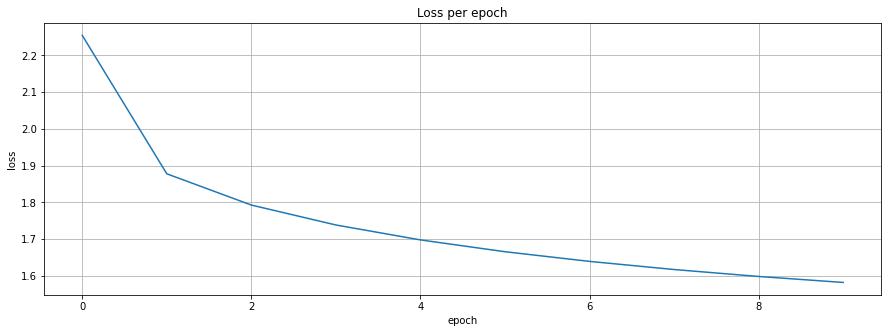

In [23]:
plot_loss_history(loss_list)

In [24]:
accuracy(nnet, data_set)

  0%|          | 0/127534 [00:00<?, ?it/s]

Total frame accuracy is 0.530

SIL: 0.96 : 21902/22816
SPN: 0.00 : 1/748
AA0: 0.00 : 0/37
AA1: 0.29 : 522/1805
AA2: 0.00 : 0/83
AE0: 0.00 : 0/48
AE1: 0.44 : 1612/3664
AE2: 0.00 : 0/102
AH0: 0.36 : 2074/5698
AH1: 0.20 : 356/1806
AH2: 0.03 : 1/30
AO0: 0.00 : 0/29
AO1: 0.57 : 1181/2058
AO2: 0.00 : 0/67
AW0: 0.00 : 0/11
AW1: 0.29 : 337/1156
AW2: 0.00 : 0/45
AY0: 0.00 : 0/35
AY1: 0.62 : 1924/3103
AY2: 0.00 : 0/168
B  : 0.32 : 499/1540
CH : 0.16 : 144/900
D  : 0.24 : 986/4031
DH : 0.29 : 545/1877
EH0: 0.00 : 0/51
EH1: 0.35 : 1017/2872
EH2: 0.00 : 0/104
ER0: 0.37 : 946/2536
ER1: 0.24 : 237/989
ER2: 0.00 : 0/20
EY0: 0.00 : 0/16
EY1: 0.57 : 1338/2347
EY2: 0.00 : 0/132
F  : 0.59 : 1385/2346
G  : 0.17 : 135/804
HH : 0.32 : 678/2106
IH0: 0.13 : 353/2622
IH1: 0.20 : 466/2283
IH2: 0.00 : 0/101
IY0: 0.43 : 901/2094
IY1: 0.44 : 989/2260
IY2: 0.00 : 0/62
JH : 0.19 : 134/715
K  : 0.50 : 1569/3126
L  : 0.65 : 2692/4167
M  : 0.45 : 1428/3189
N  : 0.63 : 3671/5872
NG : 0.29 : 384/1303
OW0: 0.01 : 1/179
OW1

In [25]:
yes_no_check(nnet, side_context)

  0%|          | 0/10 [00:00<?, ?it/s]

result: yes_fc94edb0_nohash_0       ==> YES
result: yes_ff63ab0b_nohash_0       ==> YES
result: yes_fe1916ba_nohash_0       ==> YES
result: no_41474817_nohash_0        ==> NO
result: no_49af4432_nohash_0        ==> NO
result: no_ad89eb1e_nohash_0        ==> NO
result: yes_39a12648_nohash_0       ==> YES
result: no_4394fc7c_nohash_0        ==> YES
result: no_4abb2400_nohash_0        ==> NO
result: yes_39a6b995_nohash_0       ==> YES
------------------------------------------------------------
WER is: 10.00%
Total time is: 0.91 sec
------------------------------------------------------------


In [26]:
digits_check(nnet, side_context)

  0%|          | 0/20 [00:00<?, ?it/s]

result: three_feb1d305_nohash_0     ==> THREE
result: nine_fbe51750_nohash_0      ==> NINE
result: zero_f92e49f3_nohash_3      ==> ZERO
result: one_ffa76c4a_nohash_0       ==> FOUR
result: eight_daf230ac_nohash_0     ==> EIGHT
result: nine_ccea893d_nohash_0      ==> NINE
result: two_fce65496_nohash_0       ==> TWO
result: one_fc2411fe_nohash_0       ==> NINE
result: four_ffbb695d_nohash_0      ==> FOUR
result: zero_f852895b_nohash_0      ==> ZERO
result: five_ffd2ba2f_nohash_0      ==> FIVE
result: five_f852895b_nohash_0      ==> FIVE
result: two_fb2f3242_nohash_0       ==> TWO
result: six_ffd2ba2f_nohash_0       ==> SIX
result: seven_fd32732a_nohash_0     ==> SEVEN
result: seven_fe5c4a7a_nohash_0     ==> SEVEN
result: six_ffbb695d_nohash_0       ==> SIX
result: four_fce65496_nohash_0      ==> FOUR
result: eight_da584bc0_nohash_4     ==> EIGHT
result: three_fce96bac_nohash_0     ==> THREE
------------------------------------------------------------
WER is: 10.00%
Total time is: 17.82 s

Если использовать контекст длиною в 2 кадра слева и справа, то:
- Точность на всех фреймах увеличивается с 41.3% до 53%
- WER на задаче Yes/No уменьшается с 20% до 10%
- WER на задаче Digits уменьшается с 30% до 10%

### <b>Задание №2</b> (5 баллов):
Повысить качество классификации фонем за счет улучшения архитектуры нейронной сети, оптимизатора, расписания скорости обучения, других речевых признаков и т.п. Составить небольшой отчет на основе результатов перебора использованных способов. 

### **Ответ**:

In [27]:
class MyNNet2(torch.nn.Module):

    def __init__(self, input_dim, output_dim):
        super(MyNNet2, self).__init__()
        ff_dim = 512

        self.ff_net = torch.nn.Sequential(
            nn.Linear(input_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, output_dim),
        )


    def forward(self, x):
        x = self.ff_net(x)
        return (x)

In [28]:
side_context = 5
batch_size = 256
num_epochs = 20

data_list, priors_list = combain_data(ali_dict, feats_dict, phones_dict, side_context)
data_list = np.random.permutation(data_list)
data_set = CommonDataSet(data_list, device)

nnet = MyNNet2(input_dim=(data_list[0].shape[0] - 1),
            output_dim=len(phones_dict.keys())).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nnet.parameters(), lr=3e-4, weight_decay=3e-4)

loss_list = train(
    nnet=nnet,
    data_set=data_set,
    batch_size=batch_size,
    num_epochs=num_epochs,
    criterion=criterion,
    optimizer=optimizer
)

TRAINIG STARTED...


epoch 0:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 1.5425


epoch 1:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 1.2754


epoch 2:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 1.1787


epoch 3:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 1.1120


epoch 4:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 1.0613


epoch 5:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 1.0192


epoch 6:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 0.9843


epoch 7:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 0.9532


epoch 8:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 0.9262


epoch 9:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 0.9031


epoch 10:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 0.8827


epoch 11:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 0.8644


epoch 12:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 0.8478


epoch 13:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 0.8329


epoch 14:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 0.8187


epoch 15:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 0.8067


epoch 16:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 0.7956


epoch 17:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 0.7844


epoch 18:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 0.7747


epoch 19:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 0.7657
Time is: 5 min 26 sec


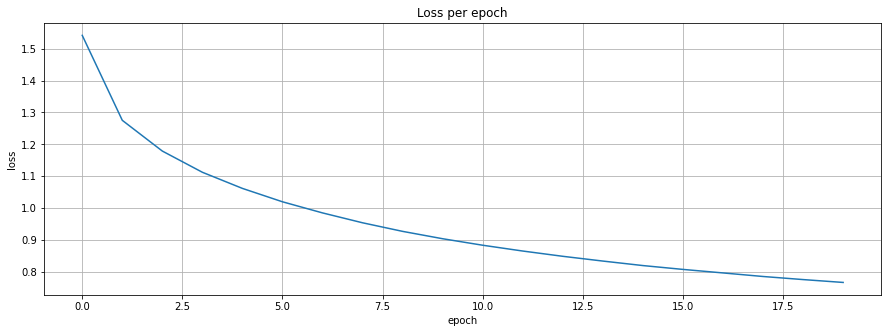

In [29]:
plot_loss_history(loss_list)

In [30]:
accuracy(nnet, data_set)

  0%|          | 0/127534 [00:00<?, ?it/s]

Total frame accuracy is 0.679

SIL: 0.97 : 22163/22942
SPN: 0.21 : 159/775
AA0: 0.10 : 6/58
AA1: 0.65 : 1198/1835
AA2: 0.20 : 15/74
AE0: 0.12 : 6/50
AE1: 0.66 : 2366/3567
AE2: 0.12 : 12/102
AH0: 0.49 : 2739/5636
AH1: 0.58 : 1063/1835
AH2: 0.20 : 8/40
AO0: 0.19 : 5/26
AO1: 0.56 : 1129/2016
AO2: 0.17 : 14/80
AW0: 0.10 : 1/10
AW1: 0.50 : 557/1103
AW2: 0.16 : 6/37
AY0: 0.16 : 6/37
AY1: 0.73 : 2213/3025
AY2: 0.30 : 55/182
B  : 0.57 : 863/1504
CH : 0.52 : 434/828
D  : 0.47 : 1849/3925
DH : 0.55 : 1091/1985
EH0: 0.30 : 18/61
EH1: 0.51 : 1451/2834
EH2: 0.11 : 12/111
ER0: 0.57 : 1492/2602
ER1: 0.39 : 367/932
ER2: 0.17 : 3/18
EY0: 0.18 : 5/28
EY1: 0.69 : 1581/2286
EY2: 0.26 : 33/126
F  : 0.74 : 1761/2364
G  : 0.48 : 392/820
HH : 0.62 : 1323/2151
IH0: 0.41 : 1039/2551
IH1: 0.42 : 972/2326
IH2: 0.12 : 12/102
IY0: 0.51 : 1094/2153
IY1: 0.71 : 1600/2260
IY2: 0.28 : 18/64
JH : 0.54 : 383/711
K  : 0.75 : 2232/2966
L  : 0.73 : 3067/4191
M  : 0.67 : 2089/3113
N  : 0.72 : 4294/5978
NG : 0.53 : 689/1294
O

In [31]:
yes_no_check(nnet, side_context)

  0%|          | 0/10 [00:00<?, ?it/s]

result: yes_fc94edb0_nohash_0       ==> YES
result: yes_ff63ab0b_nohash_0       ==> YES
result: yes_fe1916ba_nohash_0       ==> YES
result: no_41474817_nohash_0        ==> NO
result: no_49af4432_nohash_0        ==> NO
result: no_ad89eb1e_nohash_0        ==> NO
result: yes_39a12648_nohash_0       ==> YES
result: no_4394fc7c_nohash_0        ==> NO
result: no_4abb2400_nohash_0        ==> NO
result: yes_39a6b995_nohash_0       ==> YES
------------------------------------------------------------
WER is: 0.00%
Total time is: 2.16 sec
------------------------------------------------------------


In [32]:
digits_check(nnet, side_context)

  0%|          | 0/20 [00:00<?, ?it/s]

result: three_feb1d305_nohash_0     ==> THREE
result: nine_fbe51750_nohash_0      ==> NINE
result: zero_f92e49f3_nohash_3      ==> ZERO
result: one_ffa76c4a_nohash_0       ==> ONE
result: eight_daf230ac_nohash_0     ==> SIX
result: nine_ccea893d_nohash_0      ==> NINE
result: two_fce65496_nohash_0       ==> TWO
result: one_fc2411fe_nohash_0       ==> NINE
result: four_ffbb695d_nohash_0      ==> FOUR
result: zero_f852895b_nohash_0      ==> ZERO
result: five_ffd2ba2f_nohash_0      ==> FIVE
result: five_f852895b_nohash_0      ==> FIVE
result: two_fb2f3242_nohash_0       ==> TWO
result: six_ffd2ba2f_nohash_0       ==> SIX
result: seven_fd32732a_nohash_0     ==> SEVEN
result: seven_fe5c4a7a_nohash_0     ==> SEVEN
result: six_ffbb695d_nohash_0       ==> SIX
result: four_fce65496_nohash_0      ==> FOUR
result: eight_da584bc0_nohash_4     ==> EIGHT
result: three_fce96bac_nohash_0     ==> THREE
------------------------------------------------------------
WER is: 10.00%
Total time is: 46.27 sec


Архитектура используемой сети:

In [33]:
print(nnet)

MyNNet2(
  (ff_net): Sequential(
    (0): Linear(in_features=143, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=512, bias=True)
    (7): ReLU()
    (8): Linear(in_features=512, out_features=86, bias=True)
  )
)


- `learning_rate` в `Adam` был изменен на значение 3e-4
- был добавлен `weight_decay`, также равный 3e-4
- количество эпох было увеличено до 20
- использовался контекст длиной в 5 кадров слева и справа

По сравнению с предыдущим заданием:
- Точность на всех фреймах увеличилась с 53% до 67.9%
- WER на задаче Yes/No уменьшился с 10% до 0%
- WER на задаче Digits не изменился